In [1]:
import sys
sys.path.append("../../")

import os

import uuid
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely import wkt

from geowrangler import dhs
from povertymapping import settings, osm, ookla, nightlights
from povertymapping.dhs import generate_dhs_cluster_level_data, generate_dhs_household_level_data, DHSDataManager
from povertymapping.osm import OsmDataManager
from povertymapping.ookla import OoklaDataManager
import getpass
import pickle

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.model_selection import GroupKFold, cross_val_predict, cross_val_score, LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import shap

/home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext autoreload
%autoreload 2

# Experiment Details

In this notebook, we will try to run a regression model on recalculated wealth indices to account for differences between countries 

## Set up Data Access

In [3]:
# Instantiate data managers for Ookla and OSM
# This auto-caches requested data in RAM, so next fetches of the data are faster.
osm_data_manager = OsmDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")
ookla_data_manager = OoklaDataManager(cache_dir=settings.ROOT_DIR/"data/data_cache")
dhs_data_manager = DHSDataManager()

In [4]:
# Log-in using EOG credentials
username = os.environ.get('EOG_USER',None)
username = username if username is not None else input('Username?')
password = os.environ.get('EOG_PASSWORD',None)
password = password if password is not None else getpass.getpass('Password?') 

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username,password, save_token=True)

Username? jcnacpil@thinkingmachin.es
Password? ········


2023-02-06 13:22:02.901 | INFO     | povertymapping.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-02-06 13:22:02.903 | INFO     | povertymapping.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Load Countries From DHS data

In [5]:
# Set country-specific variables
country_config = {
    'Philippines': {
        'country_osm':'philippines',
        'ookla_year': 2019,
        'nightlights_year' : 2017,
        'country_code': 'ph',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/ph/PHHR71DT/PHHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/ph/PHGE71FL/PHGE71FL.shp"
    },
    'Timor Leste': {
        'country_osm':'east-timor',
        'ookla_year': 2019,
        'nightlights_year' : 2016,
        'country_code': 'tl',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/tl/TLHR71DT/TLHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/tl/TLGE71FL/TLGE71FL.shp"
    },
    'Cambodia': {
        'country_osm':'cambodia',
        'ookla_year': 2019,
        'nightlights_year' : 2014,
        'country_code': 'kh',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/kh/KHHR73DT/KHHR73FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/kh/KHGE71FL/KHGE71FL.shp"
    },
    'Myanmar': {
        'country_osm':'myanmar',
        'ookla_year': 2019,
        'nightlights_year' : 2015,
        'country_code': 'mm',
        'dhs_household_dta_path' : settings.DATA_DIR/"dhs/mm/MMHR71DT/MMHR71FL.DTA",
        'dhs_geographic_shp_path' : settings.DATA_DIR/"dhs/mm/MMGE71FL/MMGE71FL.shp"
    }
}

### Combine cluster features for all four countries
This section creates `countries_cluster_data (gpd.GeoDataFrame)` which combines DHS/Ookla/OSM/VIIRS data for all specified countries.

In [26]:
%%time

# Create list of dataframes per country, and list of all columns appearing in DHS columns
country_cluster_data_list = []
dhs_columns = ['DHSCLUST']

for country, config in country_config.items():
    print(f'Loading data for {country}')

    # Load the DHS cluster data
    dhs_household_dta_path = config['dhs_household_dta_path']
    dhs_geographic_shp_path = config['dhs_geographic_shp_path']
    country_code = config['country_code']
    dhs_gdf = dhs_data_manager.generate_dhs_cluster_level_data(
        country,
        dhs_household_dta_path, 
        dhs_geographic_shp_path, 
        col_rename_config=country_code,
        convert_geoms_to_bbox=True,
        bbox_size_km = 2.4,
        overwrite_cache=True
    ).reset_index(drop=True)

    dhs_columns = list(set(dhs_columns + list(dhs_gdf.columns)))
    

    # Generate base features for the dhs dataframe
    country_cluster_data = dhs_gdf.copy()
    country_osm = config['country_osm']
    ookla_year = config['ookla_year']
    nightlights_year = config['nightlights_year']
    
    # Add in OSM features
    country_cluster_data = osm.add_osm_poi_features(country_cluster_data, country_osm, osm_data_manager)
    country_cluster_data = osm.add_osm_road_features(country_cluster_data, country_osm, osm_data_manager)

    # Add in Ookla features
    country_cluster_data = ookla.add_ookla_features(country_cluster_data, 'fixed', ookla_year, ookla_data_manager)
    country_cluster_data = ookla.add_ookla_features(country_cluster_data, 'mobile', ookla_year, ookla_data_manager)

    # Add in the nighttime lights features
    country_cluster_data = nightlights.generate_nightlights_feature(country_cluster_data, nightlights_year) 

    country_cluster_data_list.append(country_cluster_data)

# Combine all country data into a single dataframe
countries_cluster_data = gpd.GeoDataFrame(pd.concat(country_cluster_data_list,ignore_index=True), crs=country_cluster_data_list[0].crs)


Loading data for Philippines
Overwriting Philippines in cache


2023-02-06 13:32:21.835 | DEBUG    | povertymapping.osm:load_pois:139 - OSM POIs for philippines found in cache.


Overwriting Philippines in cache


2023-02-06 13:32:26.132 | DEBUG    | povertymapping.osm:load_roads:158 - OSM Roads for philippines found in cache.
2023-02-06 13:32:29.550 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: ['2f858b388182d50703550c8ef9d321df', '5a45dc45080a935951e6c2b6c0052b13', '206a0323fa0e80f82339b66d0c859b4a', '209c2544788b8e2bdf4db4685c50e26d', '37f570ebc130cb44f9dba877fbda74e2', '1128a917060f7bb88c0a6260ed457091', 'd72ec7e4d144b750e1c0950ecad081e0', '2aff65fdf8072457cba0d42873b7a9c2']
2023-02-06 13:32:29.552 | DEBUG    | povertymapping.ookla:load_type_year_data:70 - Ookla data for aoi, fixed 2019 (key: 2f858b388182d50703550c8ef9d321df) found in cache.
2023-02-06 13:32:30.858 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: ['2f858b388182d50703550c8ef9d321df', '5a45dc45080a935951e6c2b6c0052b13', '206a0323fa0e80f82339b66d0c859b4a', '209c2544788b8e2bdf4db4685c50e26d', '37f570ebc130cb44f9dba877fbda74e2', '1128a917060f7bb88c0a6260ed4570

Loading data for Timor Leste


2023-02-06 13:32:52.781 | DEBUG    | povertymapping.osm:load_pois:139 - OSM POIs for east-timor found in cache.


Overwriting Timor Leste in cache
Overwriting Timor Leste in cache


2023-02-06 13:32:54.230 | DEBUG    | povertymapping.osm:load_roads:158 - OSM Roads for east-timor found in cache.
2023-02-06 13:32:54.315 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: ['2f858b388182d50703550c8ef9d321df', '5a45dc45080a935951e6c2b6c0052b13', '206a0323fa0e80f82339b66d0c859b4a', '209c2544788b8e2bdf4db4685c50e26d', '37f570ebc130cb44f9dba877fbda74e2', '1128a917060f7bb88c0a6260ed457091', 'd72ec7e4d144b750e1c0950ecad081e0', '2aff65fdf8072457cba0d42873b7a9c2']
2023-02-06 13:32:54.316 | DEBUG    | povertymapping.ookla:load_type_year_data:70 - Ookla data for aoi, fixed 2019 (key: 206a0323fa0e80f82339b66d0c859b4a) found in cache.
2023-02-06 13:32:54.421 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: ['2f858b388182d50703550c8ef9d321df', '5a45dc45080a935951e6c2b6c0052b13', '206a0323fa0e80f82339b66d0c859b4a', '209c2544788b8e2bdf4db4685c50e26d', '37f570ebc130cb44f9dba877fbda74e2', '1128a917060f7bb88c0a6260ed45709

Loading data for Cambodia


2023-02-06 13:33:01.196 | DEBUG    | povertymapping.osm:load_pois:139 - OSM POIs for cambodia found in cache.


Overwriting Cambodia in cache
Overwriting Cambodia in cache


2023-02-06 13:33:02.679 | DEBUG    | povertymapping.osm:load_roads:158 - OSM Roads for cambodia found in cache.
2023-02-06 13:33:03.002 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: ['2f858b388182d50703550c8ef9d321df', '5a45dc45080a935951e6c2b6c0052b13', '206a0323fa0e80f82339b66d0c859b4a', '209c2544788b8e2bdf4db4685c50e26d', '37f570ebc130cb44f9dba877fbda74e2', '1128a917060f7bb88c0a6260ed457091', 'd72ec7e4d144b750e1c0950ecad081e0', '2aff65fdf8072457cba0d42873b7a9c2']
2023-02-06 13:33:03.003 | DEBUG    | povertymapping.ookla:load_type_year_data:70 - Ookla data for aoi, fixed 2019 (key: 37f570ebc130cb44f9dba877fbda74e2) found in cache.
2023-02-06 13:33:03.240 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: ['2f858b388182d50703550c8ef9d321df', '5a45dc45080a935951e6c2b6c0052b13', '206a0323fa0e80f82339b66d0c859b4a', '209c2544788b8e2bdf4db4685c50e26d', '37f570ebc130cb44f9dba877fbda74e2', '1128a917060f7bb88c0a6260ed457091'

Loading data for Myanmar


2023-02-06 13:33:11.654 | DEBUG    | povertymapping.osm:load_pois:139 - OSM POIs for myanmar found in cache.


Overwriting Myanmar in cache
Overwriting Myanmar in cache


2023-02-06 13:33:13.186 | DEBUG    | povertymapping.osm:load_roads:158 - OSM Roads for myanmar found in cache.
2023-02-06 13:33:13.579 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: ['2f858b388182d50703550c8ef9d321df', '5a45dc45080a935951e6c2b6c0052b13', '206a0323fa0e80f82339b66d0c859b4a', '209c2544788b8e2bdf4db4685c50e26d', '37f570ebc130cb44f9dba877fbda74e2', '1128a917060f7bb88c0a6260ed457091', 'd72ec7e4d144b750e1c0950ecad081e0', '2aff65fdf8072457cba0d42873b7a9c2']
2023-02-06 13:33:13.579 | DEBUG    | povertymapping.ookla:load_type_year_data:70 - Ookla data for aoi, fixed 2019 (key: d72ec7e4d144b750e1c0950ecad081e0) found in cache.
2023-02-06 13:33:13.747 | DEBUG    | povertymapping.ookla:load_type_year_data:68 - Contents of data cache: ['2f858b388182d50703550c8ef9d321df', '5a45dc45080a935951e6c2b6c0052b13', '206a0323fa0e80f82339b66d0c859b4a', '209c2544788b8e2bdf4db4685c50e26d', '37f570ebc130cb44f9dba877fbda74e2', '1128a917060f7bb88c0a6260ed457091',

CPU times: user 1min 12s, sys: 8.22 s, total: 1min 21s
Wall time: 1min 21s


### Inspect the combined target country data

In [7]:
countries_cluster_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 87 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   DHSCLUST                           2720 non-null   int64   
 1   Wealth Index                       2720 non-null   float64 
 2   DHSID                              2720 non-null   object  
 3   DHSCC                              2720 non-null   object  
 4   DHSYEAR                            2720 non-null   float64 
 5   CCFIPS                             2720 non-null   object  
 6   ADM1FIPS                           2720 non-null   object  
 7   ADM1FIPSNA                         2720 non-null   object  
 8   ADM1SALBNA                         2720 non-null   object  
 9   ADM1SALBCO                         2720 non-null   object  
 10  ADM1DHS                            2720 non-null   float64 
 11  ADM1NAME                           

In [8]:
countries_cluster_data.head()

DHSCLUST  Wealth Index           DHSID DHSCC  DHSYEAR CCFIPS ADM1FIPS  \
0         1 -31881.608696  PH201700000001    PH   2017.0   NULL     NULL   
1         2  -2855.375000  PH201700000002    PH   2017.0   NULL     NULL   
2         3 -57647.047619  PH201700000003    PH   2017.0   NULL     NULL   
3         4 -54952.666667  PH201700000004    PH   2017.0   NULL     NULL   
4         6 -80701.695652  PH201700000006    PH   2017.0   NULL     NULL   

  ADM1FIPSNA ADM1SALBNA ADM1SALBCO  ...  mobile_2019_mean_num_tests_mean  \
0       NULL       NULL       NULL  ...                         0.008752   
1       NULL       NULL       NULL  ...                         0.198795   
2       NULL       NULL       NULL  ...                         0.075383   
3       NULL       NULL       NULL  ...                              NaN   
4       NULL       NULL       NULL  ...                              NaN   

  mobile_2019_mean_num_devices_mean  avg_rad_min avg_rad_max avg_rad_mean  \
0                          0.008752     0.226479    0.303841     0.257313   
1                          0.119334     0.261510    6.881082     1.390439   
2                          0.049202     0.224655    0.865518     0.343708   
3                               NaN     0.203245    0.264794     0.227876   
4                               NaN     0.232324    0.285085     0.250609   

  avg_rad_std  avg_rad_median  F21  F22  F23  
0    0.020025        0.260396  NaN  NaN  NaN  
1    1.719010        0.452909  NaN  NaN  NaN  
2    0.146519        0.288261  NaN  NaN  NaN  
3    0.016931        0.226401  NaN  NaN  NaN  
4    0.012259        0.246076  NaN  NaN  NaN  

[5 rows x 87 columns]

In [9]:
# Check if DHS CC can be used as a country grouping column
countries_cluster_data['DHSCC'].value_counts()

PH    1213
KH     611
TL     455
MM     441
Name: DHSCC, dtype: int64

In [10]:
# Explore as a map with first 30 columns in tooltip
countries_cluster_data.iloc[:, :30].explore()

## Data Preparation

### Hotfix for Cambodia
For the Cambodia data specifically, the drinking water column in the base files is actually separated by wet and dry season. We'll edit the cached data to add a "drinking water" column as the mean of the dry/wet columns

In [28]:
dhs_kh_household_temp = dhs_data_manager.household_data["Cambodia"].copy()
dhs_kh_household_temp[['drinking water', 'source of drinking water during the dry season', 'source of drinking water during wet season']]

drinking water  source of drinking water during the dry season  \
0                 NaN                                            43.0   
1                 NaN                                            43.0   
2                 NaN                                            51.0   
3                 NaN                                            51.0   
4                 NaN                                            43.0   
...               ...                                             ...   
15820             NaN                                            43.0   
15821             NaN                                            31.0   
15822             NaN                                            32.0   
15823             NaN                                            32.0   
15824             NaN                                            43.0   

       source of drinking water during wet season  
0                                            51.0  
1                                            43.0  
2                                            51.0  
3                                            51.0  
4                                            51.0  
...                                           ...  
15820                                        31.0  
15821                                        31.0  
15822                                        32.0  
15823                                        32.0  
15824                                        51.0  

[15825 rows x 3 columns]

In [32]:
dhs_data_manager.household_data["Cambodia"]["drinking water"] = dhs_kh_household_temp[[
    'source of drinking water during the dry season', 
    'source of drinking water during wet season']].mean(axis=1)
dhs_data_manager.household_data["Cambodia"]["drinking water"]

0        47.0
1        43.0
2        51.0
3        51.0
4        47.0
         ... 
15820    37.0
15821    31.0
15822    32.0
15823    32.0
15824    47.0
Name: drinking water, Length: 15825, dtype: float64

### Get the recomputed wealth index

After loading the DHS data using the DHSDataManager class, we can then run `recompute_index_cluster_level` to get the recomputed wealth index, pooling together data for all countries specified.

In [148]:
features = [
    "rooms",
    "electric",
    "mobile telephone",
    "radio",
    "television",
    "car/truck",
    "refrigerator",
    "motorcycle",
    "floor",
    "toilet",
    "drinking water",
]

In [149]:
# Get country list from country_config's keys
countries = list(country_config.keys())

recomputed_index_df = dhs_data_manager.recompute_index_cluster_level(countries, index_features=features)
recomputed_index_df = recomputed_index_df[['DHSID', 'country_index', 'Wealth Index', 'Recomputed Wealth Index']]

recomputed_index_df.info()

Combining household data for the ff. countries: ['Philippines', 'Timor Leste', 'Cambodia', 'Myanmar']
Combining cluster data for the ff. countries: ['Philippines', 'Timor Leste', 'Cambodia', 'Myanmar']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2720 entries, 0 to 2719
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DHSID                    2720 non-null   object 
 1   country_index            2720 non-null   object 
 2   Wealth Index             2720 non-null   float64
 3   Recomputed Wealth Index  2720 non-null   float64
dtypes: float64(2), object(2)
memory usage: 106.2+ KB


## Sense check the index output

In [150]:
household_df = dhs_data_manager.get_household_level_data_by_country(countries)
household_df[["country_index", "DHSCLUST"] + features].groupby(['country_index'])[features].count()

Combining household data for the ff. countries: ['Philippines', 'Timor Leste', 'Cambodia', 'Myanmar']


rooms  electric  mobile telephone  radio  television  \
country_index                                                         
Cambodia       15806     15823             15823  15823       15823   
Myanmar        12491     12500             12500  12500       12500   
Philippines    27496     27496             27496  27496       27496   
Timor Leste    11502     11502             11502  11502       11502   

               car/truck  refrigerator  motorcycle  floor  toilet  \
country_index                                                       
Cambodia           15822         15823       15823  15824   15821   
Myanmar            12500         12500       12500  12500   12500   
Philippines        27496         27496       27496  27496   27496   
Timor Leste        11502         11502       11502  11502   11502   

               drinking water  
country_index                  
Cambodia                15821  
Myanmar                 12500  
Philippines             27496  
Timor Leste             11502

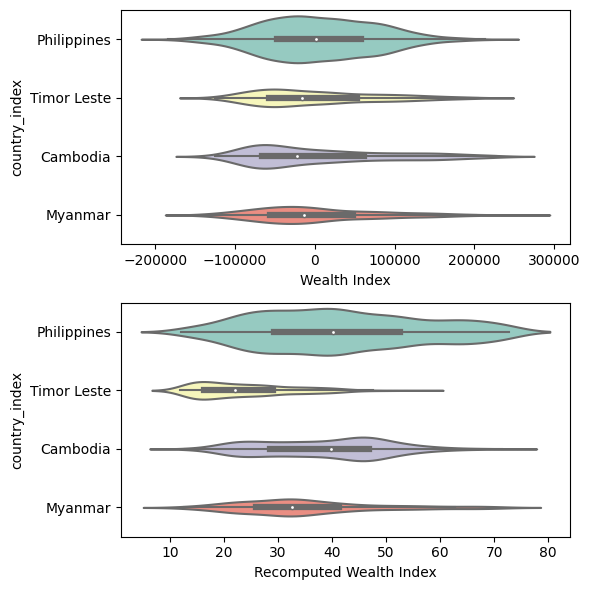

In [151]:
# Check differences between distributions
sns.set_palette("Set3", 4)
fig, axes = plt.subplots(2, 1, figsize=(6,6))
sns.violinplot(data=recomputed_index_df, x="Wealth Index", y="country_index", scale="count", ax=axes[0])
sns.violinplot(data=recomputed_index_df, x="Recomputed Wealth Index", y="country_index", scale="count", ax=axes[1])
plt.tight_layout()

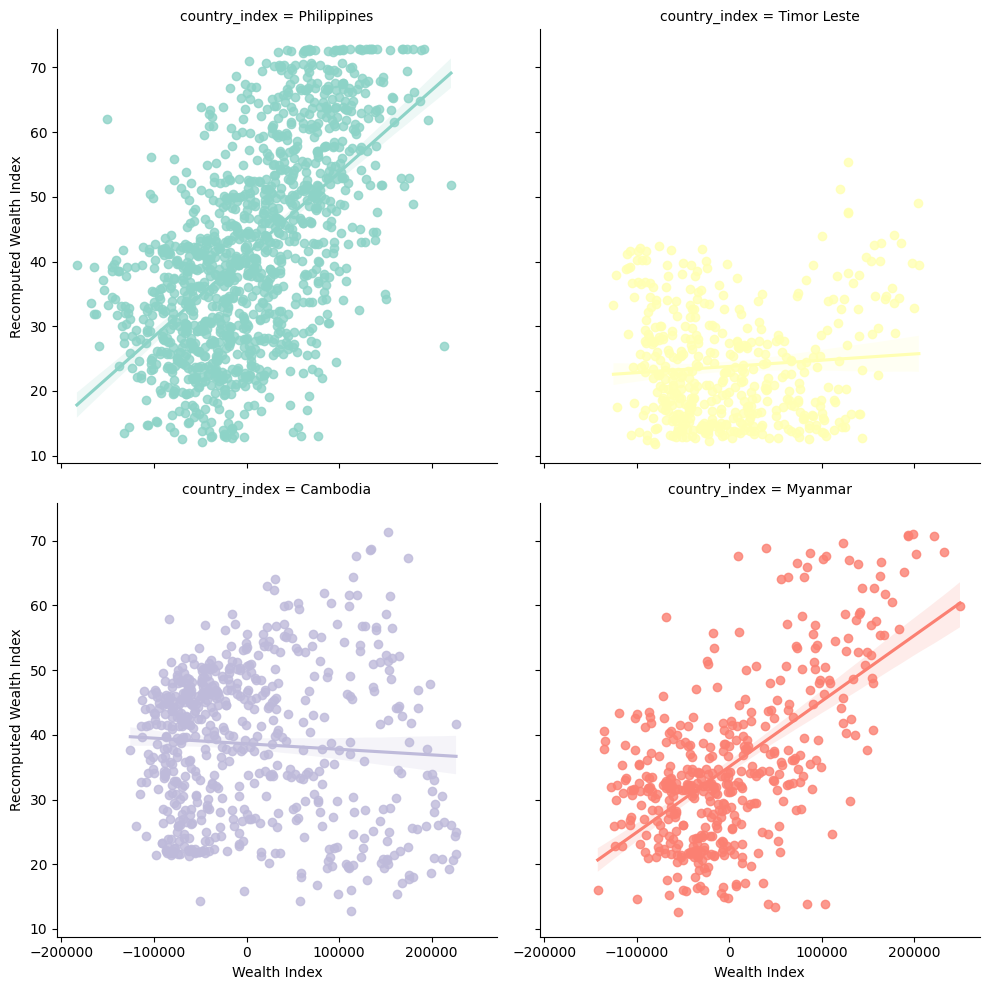

In [152]:
sns.lmplot(data=recomputed_index_df, x='Wealth Index', y='Recomputed Wealth Index', col='country_index', hue='country_index', col_wrap=2)

In [153]:
recomputed_index_df.groupby('country_index')[['Wealth Index','Recomputed Wealth Index']].corr().unstack().iloc[:,1]

country_index
Cambodia      -0.064569
Myanmar        0.607073
Philippines    0.583243
Timor Leste    0.082531
Name: (Wealth Index, Recomputed Wealth Index), dtype: float64

In [154]:
## Join the wealth index to countries_cluster_data
countries_pooled_index_data = countries_cluster_data.merge(recomputed_index_df[['DHSID', 'Recomputed Wealth Index']], on='DHSID')

### Split into labels and features

In [155]:
# Set parameters
label_col = 'Recomputed Wealth Index'
# label_col = 'Wealth Index'
# normalize_labels = 'single-country' # False, 'cross-country' or 'single_country'
# normalize_labels = 'cross-country'
normalize_labels = False

In [156]:
# Split train/test data into features and labels

# For labels, we just select the target label column
labels = countries_pooled_index_data[[label_col]]

# For features, drop all columns from the input dhs files
# If you need the cluster data, refer to country_data / country_test
features = countries_pooled_index_data.drop(dhs_columns + ['Recomputed Wealth Index'], axis=1)

features.shape, labels.shape

((2720, 61), (2720, 1))

### Normalize labels

In [157]:
if normalize_labels is not False:
    scaler = MinMaxScaler(feature_range=(0,1))
    if normalize_labels == 'cross-country':      
        labels[labels.columns] = scaler.fit_transform(labels)
    elif normalize_labels == 'single-country':
        labels_temp = labels.copy()
        labels_temp['group_col'] = countries_pooled_index_data['DHSCC']
        labels_temp[f'{label_col}_scaled'] = labels_temp.groupby('group_col', group_keys=False)[label_col].apply(lambda x: (x-min(x))/(max(x)-min(x)))
        labels[label_col] = labels_temp[f'{label_col}_scaled']
display(labels)

Recomputed Wealth Index
0                   18.080350
1                   16.439871
2                   31.709942
3                   22.203231
4                   33.894957
...                       ...
2715                44.715195
2716                25.647813
2717                42.631003
2718                31.750987
2719                55.465443

[2720 rows x 1 columns]

In [158]:
features.columns

Index(['poi_count', 'atm_count', 'atm_nearest', 'bank_count', 'bank_nearest',
       'bus_station_count', 'bus_station_nearest', 'cafe_count',
       'cafe_nearest', 'charging_station_count', 'charging_station_nearest',
       'courthouse_count', 'courthouse_nearest', 'dentist_count',
       'dentist_nearest', 'fast_food_count', 'fast_food_nearest',
       'fire_station_count', 'fire_station_nearest', 'food_court_count',
       'food_court_nearest', 'fuel_count', 'fuel_nearest', 'hospital_count',
       'hospital_nearest', 'library_count', 'library_nearest',
       'marketplace_count', 'marketplace_nearest', 'pharmacy_count',
       'pharmacy_nearest', 'police_count', 'police_nearest', 'post_box_count',
       'post_box_nearest', 'post_office_count', 'post_office_nearest',
       'restaurant_count', 'restaurant_nearest', 'social_facility_count',
       'social_facility_nearest', 'supermarket_count', 'supermarket_nearest',
       'townhall_count', 'townhall_nearest', 'road_count',
     

In [159]:
# Clean features
# For now, just impute nans with 0
# TODO: Implement other cleaning steps
features = features.fillna(0)

### Base Features List

The features can be subdivided by the source dataset

#### OSM
- `<poi type>_count`: number of points of interest (POI) of a specified type in that area
    - ex. atm_count: number of atms in cluster
    - poi_count: number of all POIs *of all types* in cluster 
- `<poi_type>_nearest`: distance of nearest POI of the specified type
    - ex. atm_nearest: distance of nearest ATM from that cluster
- OSM POI types included: `atm`, `bank`, `bus_stations`, `cafe`, `charging_station`, `courthouse`, `dentist` (clinic), `fast_food`, `fire_station`, `food_court`, `fuel` (gas station), `hospital`, `library`, `marketplace`, `pharmacy`, `police`, `post_box`, `post_office`, `restaurant`, `social_facility`, `supermarket`, `townhall`, `road`

#### Ookla 
The network metrics features follow the following name convention:

> `<type>_<year>_<yearly aggregate>_<network variable>_<cluster aggregate>`

- type: kind of network connection measured
    - fixed: connection from fixed sources (landline, fiber, etc.)
    - mobile: connection from mobile devices
- year: Year of source data
- yearly aggregate: How data was aggregated into yearly data
    - Note: Ookla provides data per quarter, so a yearly mean takes the average across 4 quarters
    - For this model, we only aggregate by yearly mean
- network variable: network characteristic described
    - avg_d_kbps: average download speed in kbps
    - avg_u_kbps: average upload speed in kbps
    - avg_lat_ms: average latency in ms
    - num_devices: number of devices measured
- cluster aggregate: how the data was aggregated per cluster aggregate
    - Types: min, mean, max, median, std.
        - For this model: only mean is used 
    - This is calculated using area zonal stats, which weighs the average by the intersection of the Ookla tile with the cluster geometry.
    
    
Ex. `fixed_2019_mean_avg_d_kbps_median` takes the cluster median of 2019 yearly average download speed.


#### Nightlights (VIIRS)
All nightlights features are taken as the zonal aggregate of the raster data per cluster

- ex. `avg_rad_mean`: cluster mean of the average radiance 
- aggregations used: min, mean, max, median


In [160]:
features.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2720 entries, 0 to 2719
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   poi_count                          2720 non-null   float64
 1   atm_count                          2720 non-null   float64
 2   atm_nearest                        2720 non-null   float64
 3   bank_count                         2720 non-null   float64
 4   bank_nearest                       2720 non-null   float64
 5   bus_station_count                  2720 non-null   float64
 6   bus_station_nearest                2720 non-null   float64
 7   cafe_count                         2720 non-null   float64
 8   cafe_nearest                       2720 non-null   float64
 9   charging_station_count             2720 non-null   float64
 10  charging_station_nearest           2720 non-null   float64
 11  courthouse_count                   2720 non-null

## Model Training

In [161]:
# Set parameters
groupkfold_col = 'DHSCC'
# cv_num_splits = 5
# cv_num_repeats = 5
train_test_seed = 42
test_size = 0.2

### Create train/test cross-validation indices

In [162]:
# train_features, test_features, train_labels, test_labels = train_test_split(
#     features, labels, test_size=test_size, random_state=train_test_seed
# )

# Cross validation
print(f"Performing GroupKFold CV with groups based on DHSCC...")
groups = countries_pooled_index_data[groupkfold_col].values
cv = GroupKFold(n_splits = len(set(groups)))

print(cv.split(features, groups=groups))
print(f'Number of splits based on DHSCC unique values: {cv.get_n_splits()}')


Performing GroupKFold CV with groups based on DHSCC...
<generator object _BaseKFold.split at 0x7f2564373eb0>
Number of splits based on DHSCC unique values: 4


### Instantiate model
For now, we will train a simple random forest model

In [163]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=train_test_seed, verbose=0)
model

RandomForestRegressor(random_state=42)

### Evaluate model training using cross-validation
We evalute the model's generalizability when training over different train/test splits

Ideally for R^2

- We want a high mean: This means that we achieve a high model performance over the different train/test splits
- We want a low standard deviation (std): This means that the model performance is stable over multiple training repetitions

Split# 1
Train countries (num samples): {'KH', 'TL', 'MM'} (1507)
Test countries (num samples): {'PH'} (1213)
Split r^2: -0.01 



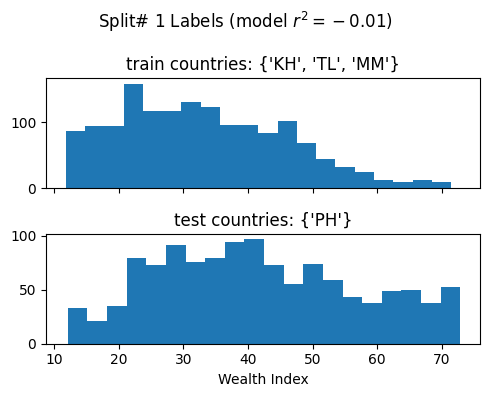

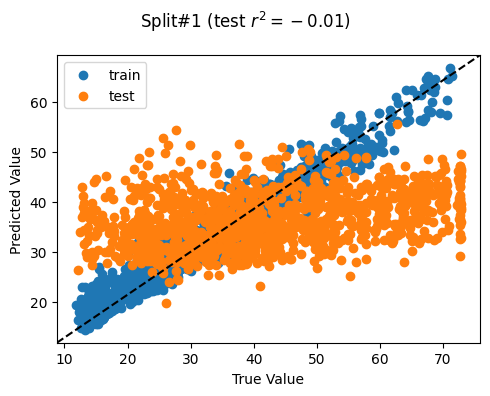

Split# 2
Train countries (num samples): {'MM', 'TL', 'PH'} (2109)
Test countries (num samples): {'KH'} (611)
Split r^2: -1.45 



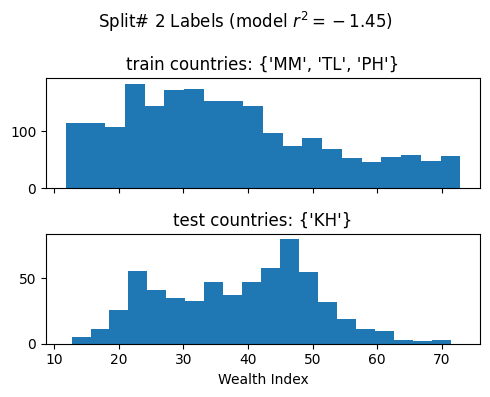

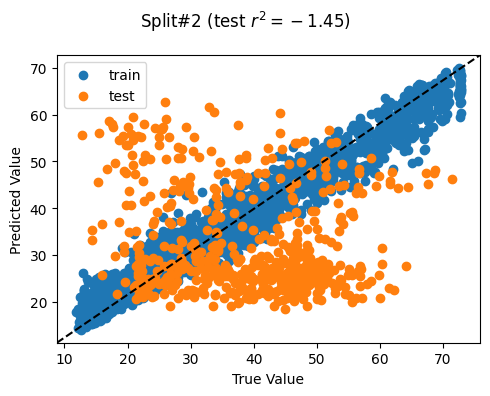

Split# 3
Train countries (num samples): {'KH', 'MM', 'PH'} (2265)
Test countries (num samples): {'TL'} (455)
Split r^2: -2.74 



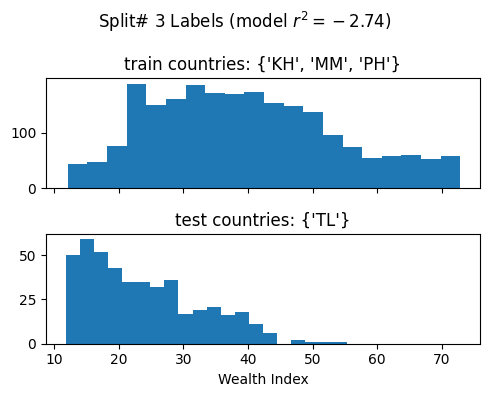

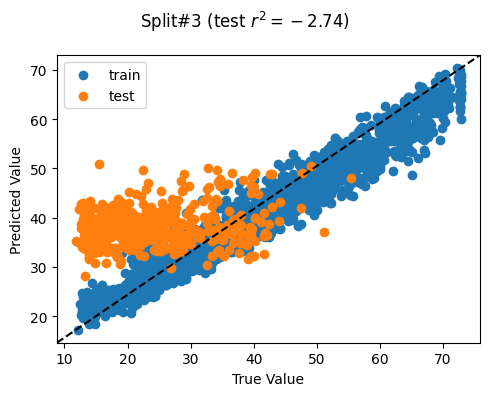

Split# 4
Train countries (num samples): {'KH', 'TL', 'PH'} (2279)
Test countries (num samples): {'MM'} (441)
Split r^2: 0.01 



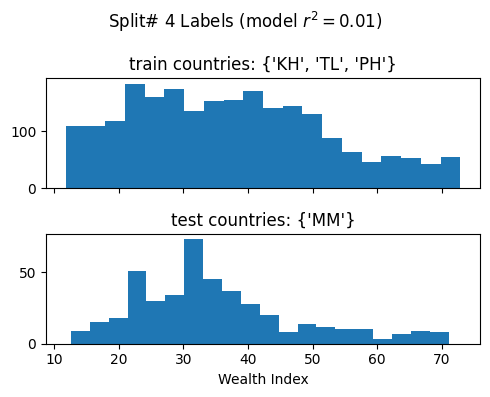

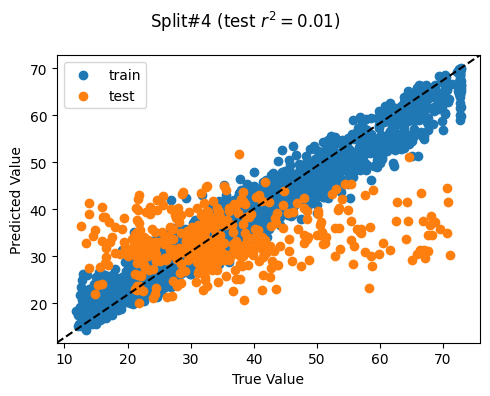

Mean split r^2  (std): -1.05 (1.14)


In [164]:
sns.set_palette("tab10")
split_r2_list = []

for i, (train, test) in enumerate(cv.split(features, labels,groups=groups)):
    print(f'Split# {i+1}')

    # Print info about current split
    train_labels = set(groups[train])
    test_labels = set(groups[test])
    print(f'Train countries (num samples): {train_labels} ({len(train)})')
    print(f'Test countries (num samples): {test_labels} ({len(test)})')

    # Split data into train/test
    X_train = features.values[train]
    X_test = features.values[test]
    y_train = labels.values.ravel()[train]
    y_test = labels.values.ravel()[test]

    # print('Input shapes (X_train, X_test, y_train, y_test): ',np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

    # Train model and get r2
    model.fit(X_train, y_train)
    split_r2 = r2_score(y_test, model.predict(X_test))
    split_r2_list.append(split_r2)
    print(f'Split r^2: {round(split_r2,2)} \n')

    # Plot histogram of labels
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(5,4))
    ax[0].hist(y_train, bins=20)
    ax[0].set_title(f'train countries: {train_labels}')
    ax[1].hist(y_test, bins=20)
    ax[1].set_title(f'test countries: {test_labels}')
    ax[1].set_xlabel('Wealth Index')
    fig.suptitle(f'Split# {i+1} Labels (model $r^2 = {round(split_r2,2)}$)')
    plt.tight_layout()
    plt.show()

    # Plot scatter plot
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    ax.scatter(y_train, model.predict(X_train), label="train")
    ax.scatter(y_test, model.predict(X_test), label="test")
    ax.plot([0,1],[0,1], transform=ax.transAxes, linestyle='dashed', color='k')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    ax.legend()    
    fig.suptitle(f'Split#{i+1} (test $r^2 = {round(split_r2,2)}$)')
    plt.tight_layout()
    plt.show()
split_r2_mean = round(np.array(split_r2_list).mean(), 2)
split_r2_std = round(np.array(split_r2_list).std(), 2)
print(f'Mean split r^2  (std): {split_r2_mean} ({split_r2_std})')



## Exploratory Data Analysis

### Per-country wealth index

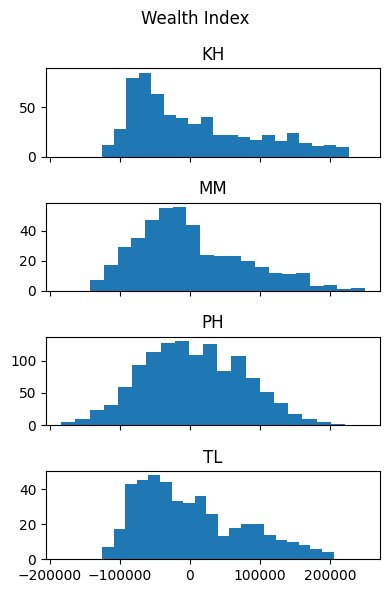

In [165]:
countries_pooled_index_data['Wealth Index'].hist(by=countries_pooled_index_data['DHSCC'], figsize = (4,6),layout=(4,1),  sharex=True, xrot=0, bins=20)
plt.suptitle('Wealth Index')
plt.tight_layout()
plt.show()

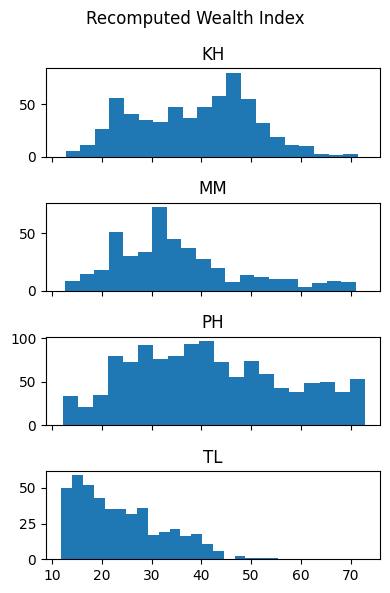

In [166]:
countries_pooled_index_data['Recomputed Wealth Index'].hist(by=countries_pooled_index_data['DHSCC'], figsize = (4,6),layout=(4,1),  sharex=True, xrot=0, bins=20)
plt.suptitle('Recomputed Wealth Index')
plt.tight_layout()
plt.show()

## Per-country features

In [167]:
features.columns

Index(['poi_count', 'atm_count', 'atm_nearest', 'bank_count', 'bank_nearest',
       'bus_station_count', 'bus_station_nearest', 'cafe_count',
       'cafe_nearest', 'charging_station_count', 'charging_station_nearest',
       'courthouse_count', 'courthouse_nearest', 'dentist_count',
       'dentist_nearest', 'fast_food_count', 'fast_food_nearest',
       'fire_station_count', 'fire_station_nearest', 'food_court_count',
       'food_court_nearest', 'fuel_count', 'fuel_nearest', 'hospital_count',
       'hospital_nearest', 'library_count', 'library_nearest',
       'marketplace_count', 'marketplace_nearest', 'pharmacy_count',
       'pharmacy_nearest', 'police_count', 'police_nearest', 'post_box_count',
       'post_box_nearest', 'post_office_count', 'post_office_nearest',
       'restaurant_count', 'restaurant_nearest', 'social_facility_count',
       'social_facility_nearest', 'supermarket_count', 'supermarket_nearest',
       'townhall_count', 'townhall_nearest', 'road_count',
     

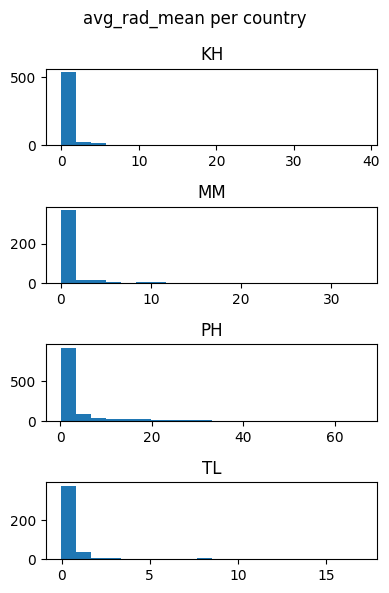

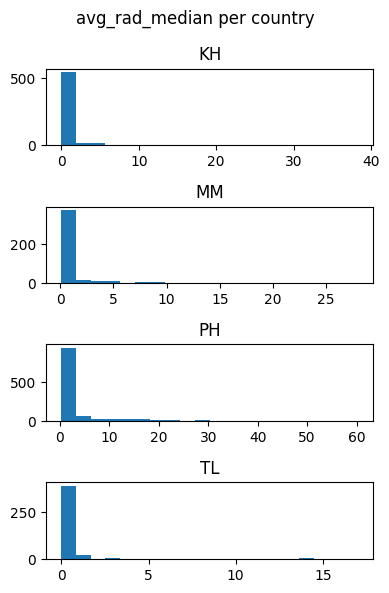

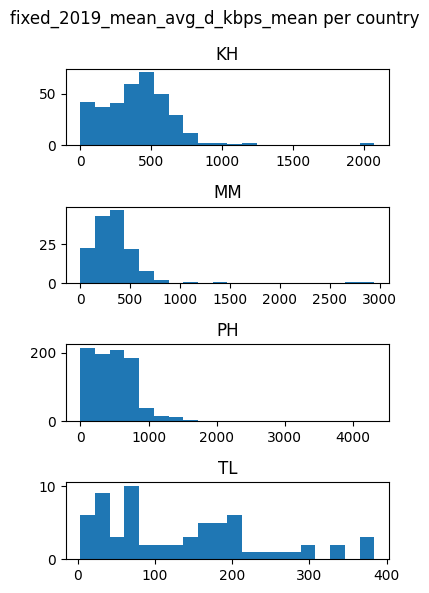

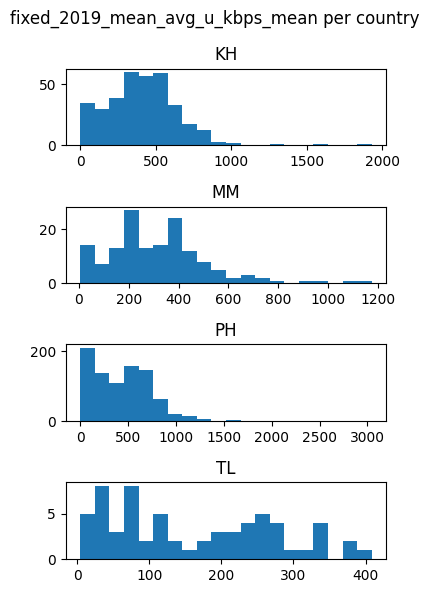

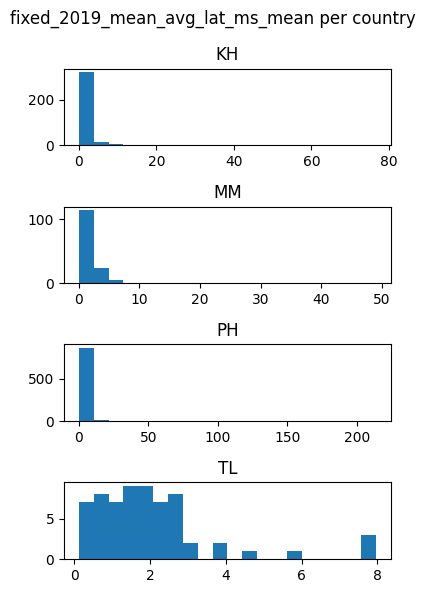

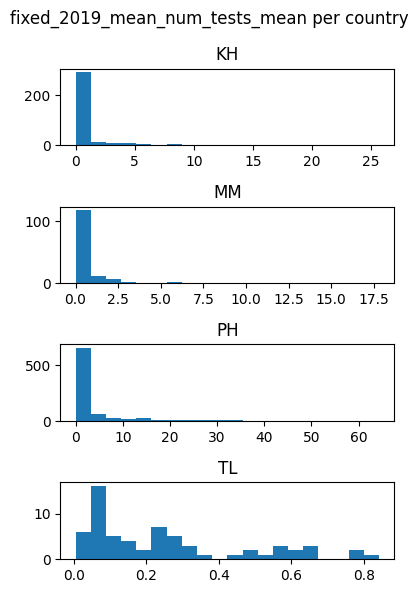

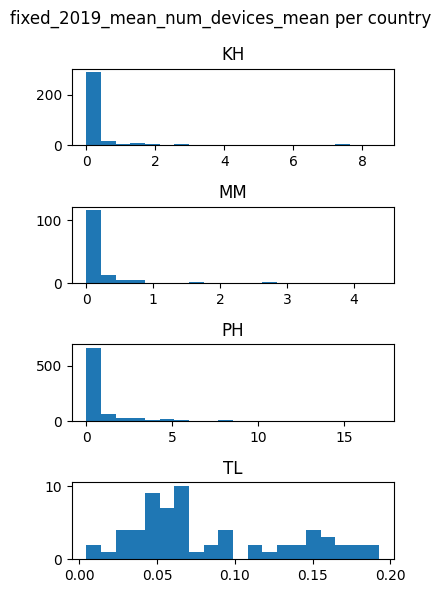

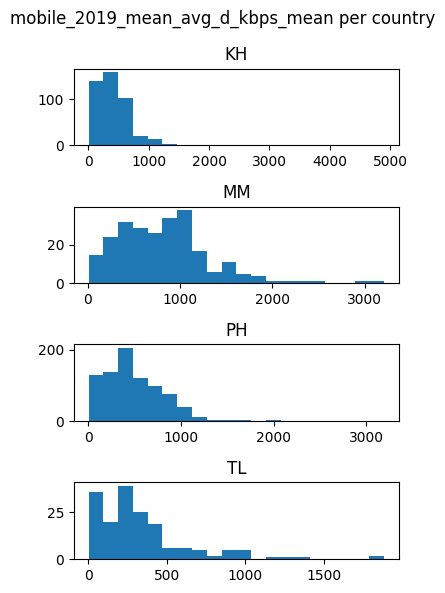

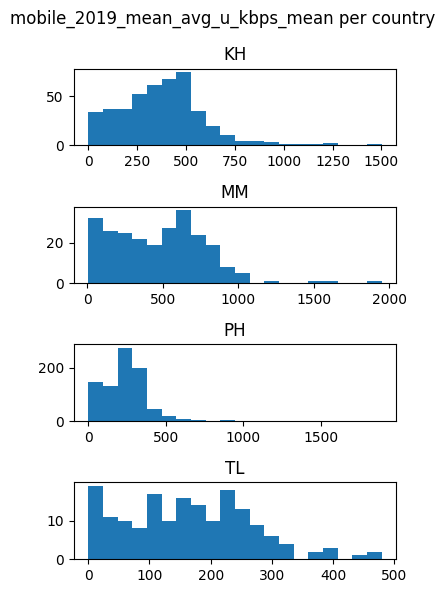

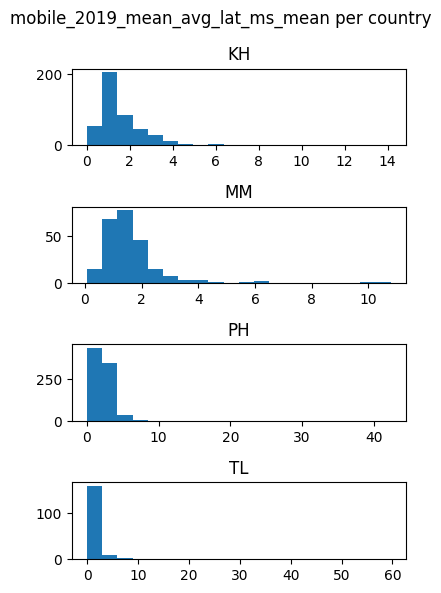

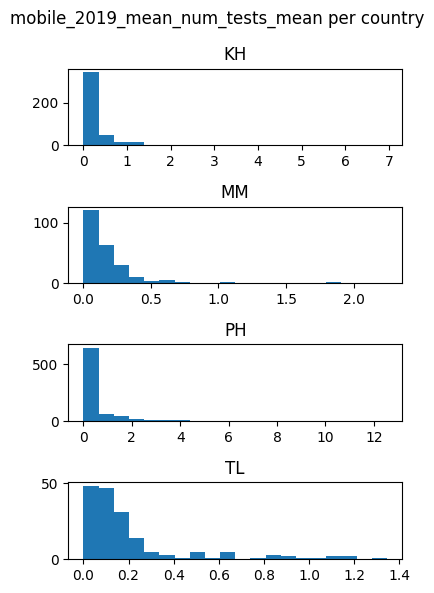

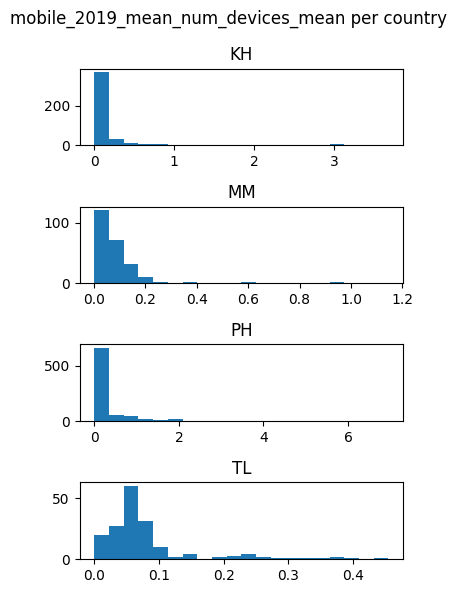

In [168]:
features_list = [
    'avg_rad_mean', 
    'avg_rad_median', 
    'fixed_2019_mean_avg_d_kbps_mean', 
    'fixed_2019_mean_avg_u_kbps_mean',
    'fixed_2019_mean_avg_lat_ms_mean', 
    'fixed_2019_mean_num_tests_mean',
    'fixed_2019_mean_num_devices_mean', 
    'mobile_2019_mean_avg_d_kbps_mean',
    'mobile_2019_mean_avg_u_kbps_mean', 
    'mobile_2019_mean_avg_lat_ms_mean',
    'mobile_2019_mean_num_tests_mean', 
    'mobile_2019_mean_num_devices_mean',
]

for feature in features_list:
    countries_pooled_index_data[feature].hist(by=countries_pooled_index_data['DHSCC'], figsize = (4,6),layout=(4,1), xrot=0, bins=20)
    plt.suptitle(f'{feature} per country')
    plt.tight_layout()
    plt.show()